# Convolution Neural Networks

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

## Simple CNN Structure in MNIST

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyper-parameters
input_size = 1     #Gray-scale images
classes    = 10
lr         = 0.001
batch_size = 128
epochs     = 5

Using device: cuda


**Data Preprocessing**

In [6]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.1307, ), (0.3081, )) #Mean and Std of MNIST 
])

train_dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = transform)
test_dataset  = datasets.MNIST(root = "./data", train = False, download = True, transform = transform)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader  = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

100.0%
100.0%
100.0%
100.0%


**CNN Structure**

In [7]:
class SimpleCNN(nn.Module):
	def __init__(self, inplanes = 1, num_classes = 10):
		super(SimpleCNN, self).__init__()
		# Input 1 x 28 x 28
		# CONV1:
		self.conv1 = nn.Conv2d(in_channels = inplanes, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
			#Output: 32 x 14 x 14
		# CONV2:
		self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
		self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
			#Output: 64 x 7 x 7
		#Flatten & Dense
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.fc2 = nn.Linear(128, num_classes)
		
	def forward(self, x):
		#Conv1
		x = self.conv1(x)
		x = F.relu(x)
		x = self.pool1(x)
		#Conv2
		x = self.pool2(F.relu(self.conv2(x)))
		#Flatten
		x = x.view(x.size(0), -1)
		#Dense
		x = self.fc1(x)
		x = F.relu(x)
		x = self.fc2(x)
		
		return x

**Training**

In [9]:
# Init
model = SimpleCNN(inplanes = input_size, num_classes = classes).to(device)
print(model)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss() # Softmax Included
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training
for epoch in range(epochs):
    #Training mode
    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data    = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
		
        # Backward pass and Criterion
        optimizer.zero_grad()
        loss.backward()       #Gradient
        optimizer.step()      #Update weights
		
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
		
    print(f'--- Epoch {epoch+1} Finished, Average Loss: {running_loss/len(train_loader):.4f} ---')

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [1/5], Step [100/469], Loss: 0.1837
Epoch [1/5], Step [200/469], Loss: 0.0833
Epoch [1/5], Step [300/469], Loss: 0.0373
Epoch [1/5], Step [400/469], Loss: 0.0615
--- Epoch 1 Finished, Average Loss: 0.1792 ---
Epoch [2/5], Step [100/469], Loss: 0.1020
Epoch [2/5], Step [200/469], Loss: 0.0489
Epoch [2/5], Step [300/469], Loss: 0.0163
Epoch [2/5], Step [400/469], Loss: 0.0170
--- Epoch 2 Finished, Average Loss: 0.0470 ---
Epoch [3/5], Step [100/469], Loss: 0.0159
Epoch [3/5], Step [200/469], Loss: 0.0264
Epoch [3/5], Step [300/4

**Evaluation**

In [10]:
# Evaluation mode
model.eval()
test_loss = 0
correct   = 0
total     = 0

with torch.no_grad():
    for data, targets in test_loader:
        data    = data.to(device)
        targets = targets.to(device)
        outputs = model(data)
		
        loss = criterion(outputs, targets)
        test_loss += loss.item()
		
        _, predicted = torch.max(outputs.data, 1)
        total   += targets.size(0)
        correct += (predicted == targets).sum().item()

test_loss /= len(test_loader)
accuracy   = correct / total * 100.0
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.0317
Test Accuracy: 98.95%


**Test**

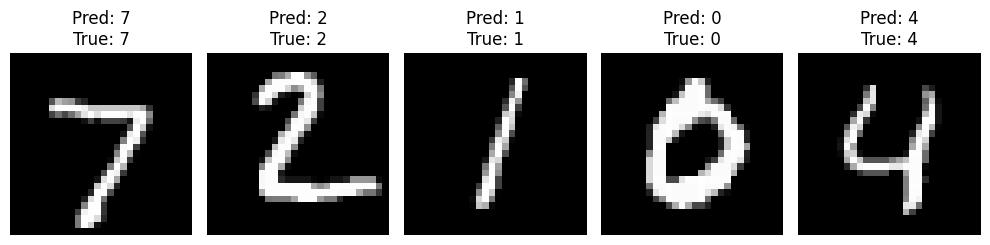

In [11]:
model.eval()
with torch.no_grad():
    data, targets = next(iter(test_loader))
    data = data.to(device)
    outputs = model(data)
    _, predicted_labels = torch.max(outputs.data, 1)
	
    # CPU
    data_cpu = data.cpu()
    targets_cpu = targets.cpu()
    predicted_labels_cpu = predicted_labels.cpu()
	
    # Visualization function
    def imshow(img):
        img   = img * 0.3081 + 0.1307 # Un-normalize: img * std + mean
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray') # Bỏ chiều kênh nếu là ảnh xám
        plt.axis('off')
		
    # Visulize
    num_images_to_show = 5
    plt.figure(figsize=(10, 3))
    for i in range(num_images_to_show):
        plt.subplot(1, num_images_to_show, i+1)
        imshow(data_cpu[i])
        plt.title(f"Pred: {predicted_labels_cpu[i].item()}\nTrue: {targets_cpu[i].item()}")
    plt.tight_layout()
    plt.show()

****